<a href="https://colab.research.google.com/github/Thebestneminever/Deep-Learning-Projects/blob/main/Neural_machine_translation_using_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
from nltk.translate.bleu_score import SmoothingFunction
smoothie = SmoothingFunction().method4
from nltk.translate.bleu_score import sentence_bleu

import json

from collections import defaultdict

In [ ]:

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))


Found GPU at: /device:GPU:0


In [ ]:
# download the file
# first we get the file from cloud
path_to_zip = tf.keras.utils.get_file('spa-eng.zip', origin = 'http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip',extract=True)
# making a new file 
path_to_file = os.path.dirname(path_to_zip) + "/spa-eng/spa.txt"

2646016/2638744 [==============================] - 0s 0us/step


In [ ]:
# convering unicode to ascii
def unicode_to_ascii(s):
  return ''.join(c for c in unicodedata.normalize('NFD',s) if unicodedata.category(c) != 'Mn')



In [ ]:
# preprocessing the sentences
def preprocess_sentence(w):
  w = unicode_to_ascii(w.lower().strip()) 
  w = re.sub(r"([?.!,¿])",r" \1 ",w)
  w = re.sub(r'[" "]+'," ",w)
  w = re.sub(r"[^a-zA-Z?.!,¿]+"," ",w)
  w = w.strip()
  w = '<start> ' + w + ' <end>'
  return w



In [ ]:
en_sentence = u"May I borrow this book?"
sp_sentence = u"¿Puedo tomar prestado este libro?"
print(preprocess_sentence(en_sentence))
print(preprocess_sentence(sp_sentence).encode('utf-8'))


<start> may i borrow this book ? <end>
b'<start> \xc2\xbf puedo tomar prestado este libro ? <end>'


In [ ]:
def create_dataset(path,num_examples):
  lines = io.open(path,encoding='UTF-8').read().strip().split('\n')
  word_pairs  = [[preprocess_sentence(w) for w in l.split('\t')] for l in lines[:num_examples]]
  return zip(*word_pairs)

In [ ]:
en,sp = create_dataset(path_to_file,None)
print(en[100])
print(sp[100])

<start> go away ! <end>
<start> salga de aqui ! <end>


In [ ]:
def tokenize(lang):# i dont know what the hell is this ! Come back to this later

  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='') # create a tokenizer object
  lang_tokenizer.fit_on_texts(lang) # tokenize the lang 
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,padding='post')
  return tensor,lang_tokenizer

In [ ]:
def load_dataset(path,num_examples=None):
  targ_lang, inp_lang = create_dataset(path,num_examples)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [ ]:
num_examples = 50000
input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer = load_dataset(path_to_file,num_examples)

In [ ]:

max_len_targ, max_len_inp = target_tensor.shape[1], input_tensor.shape[1]

spa_word2index["SENTATE"]

In [ ]:
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)


In [ ]:

input_tensor_train.shape

(40000, 16)

In [ ]:
input_tensor_val.shape

(10000, 16)

In [ ]:
def convert(lang_tokenizer,tensor):
  for t in tensor:
    if t:
      print(f"{t} ----> {lang_tokenizer.index_word[t]}")
    else:
      print(f"{t} ----> pad")

In [ ]:
convert(inp_lang_tokenizer,input_tensor_train[0])

1 ----> <start>
2294 ----> salga
116 ----> del
2415 ----> automovil
3 ----> .
2 ----> <end>
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad


In [ ]:
convert(targ_lang_tokenizer,target_tensor_train[0])

1 ----> <start>
60 ----> who
8 ----> is
20 ----> that
159 ----> man
7 ----> ?
2 ----> <end>
0 ----> pad
0 ----> pad
0 ----> pad
0 ----> pad


In [ ]:
BUFFER_SIZE = input_tensor_train.shape[0]# total number of training examples
BATCH_SIZE = 64 # batch size
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE

embedding_dim = 256 # per word
units = 1024 # in pre-attention model
vocab_inp_size = len(inp_lang_tokenizer.word_index) + 1 # 1 for <unk> or zero pad
vocab_tar_size = len(targ_lang_tokenizer.word_index) + 1 # 1 for <unk> or zero pad


In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train,target_tensor_train)).shuffle(BUFFER_SIZE)

In [ ]:
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True) # drops the last examples if it dosent make a perfect batch size

In [ ]:
example_input_batch, example_target_batch = next(iter(dataset))

In [ ]:
class Encoder(tf.keras.Model):
  def __init__(self,vocab_size, embedding_dim, enc_units):
    super(Encoder,self).__init__()
    self.enc_units = enc_units # the number of hidden units in the pre-attention bi-LSTM
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim) # this is the embedding layer 
    # for embedding  layer
    # input shape: 2D tensor with shape: (batch_size, input_length=max length of the input sequence ).
    #Output shape: 3D tensor with shape: (batch_size, input_length=max length of the input sequence, output_dim=embedding_dim).
    self.lstm1 = tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True,recurrent_initializer='glorot_uniform')
    self.lstm2 = tf.keras.layers.LSTM(self.enc_units, return_sequences=True, return_state=True,recurrent_initializer='glorot_uniform')
  
  def call(self, input):
    x = self.embedding(input)
    whole_seq_output_1,final_memory_state_1, final_carry_state_1 = self.lstm1(x)
    whole_seq_output_2,final_memory_state_2, final_carry_state_2 = self.lstm2(x)
    whole_seq_output = tf.concat([whole_seq_output_1,whole_seq_output_2],axis=-1)
    final_memory_state = tf.divide(tf.add(final_memory_state_1,final_memory_state_2),2)
    return whole_seq_output,final_memory_state



In [ ]:
encoder = Encoder(vocab_inp_size,embedding_dim,units) # please come back for trained embeddings

In [ ]:
#sample 
sample_output,sample_hidden = encoder(example_input_batch)

In [ ]:
class BahdanuaAttentionLayer(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanuaAttentionLayer,self).__init__()
    self.dense1 = tf.keras.layers.Dense(units)
    self.dense2 = tf.keras.layers.Dense(units)
    self.dense3 = tf.keras.layers.Dense(1)
  def call(self,prev_hidden,pre_attention_values):
    prev_hidden = tf.expand_dims(prev_hidden,1)
    linear_p_h = self.dense1(prev_hidden)
    linear_p_a_v = self.dense2(pre_attention_values)
    energies = tf.nn.tanh(linear_p_h + linear_p_a_v)
    attention_weights = tf.nn.softmax(self.dense3(energies),axis=1)

    context_vector = tf.reduce_sum(pre_attention_values*attention_weights, axis=1)
    return context_vector, attention_weights


In [ ]:
attention_layer = BahdanuaAttentionLayer(10) # global layer, for parameter sharing 
attention_result, attention_weights = attention_layer(sample_hidden,sample_output)


In [ ]:
class Decoder(tf.keras.Model):
  def __init__(self, target_vocab_size, dec_units, embedding_dim):
    super(Decoder,self).__init__()
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(target_vocab_size,embedding_dim)
    self.lstm  = tf.keras.layers.LSTM(self.dec_units,recurrent_initializer="glorot_uniform", return_sequences=True, return_state=True)
    self.fc = tf.keras.layers.Dense(target_vocab_size)
    self.attention = BahdanuaAttentionLayer(412) 
  def call(self, input_to_decoder, pre_attention_values, prev_hidden,bsz=64,prev_cell=None):
    # input_to_decoder = (batch_size, 1)
    # prev_hidden = (batch_size, dec_units)
    # pre_attention_values = (batch_size, inp_seq_length, enc_hidden)
    # prev_cell = (batch_size, dec_units)
    context_vector, attention_weights = self.attention(prev_hidden, pre_attention_values)
    # context_vector = (batch, enc_hidden)
    context_vector = tf.expand_dims(context_vector, axis=1)
    # context_vector = (batch,1, enc_hidden)
    input_to_decoder = self.embedding(input_to_decoder)
    # input_to_decoder = (batch, 1, embedding_dim)
    input_to_decoder_final  = tf.concat([context_vector, input_to_decoder],axis=-1)
    # input_to_decoder_final = (batch,1 , embedding_dim + enc_hidden)
    if prev_cell==None:
      prev_hidden,prev_cell = tf.zeros(shape=(bsz,self.dec_units)), tf.zeros(shape=(bsz,self.dec_units))

    output, state, cell = self.lstm(inputs=input_to_decoder_final, initial_state=[prev_hidden, prev_cell])
    # output = (batch, 1, dec_units), state =  (batch , dec_units), cell = (batch, dec_units)
    output = tf.reshape(output, shape=(-1, output.shape[2]))

    y = self.fc(output) # (batch_size, target_vocab_size = basically a one hot )

    return y, state, cell, attention_weights

In [ ]:
decoder =  Decoder(vocab_tar_size,units,embedding_dim)

In [ ]:
sample_decoder_output, ss,cc,a_w = decoder(tf.random.uniform(shape=(BATCH_SIZE,1)),sample_output,sample_hidden)

In [ ]:
optimizer = tf.keras.optimizers.Adam() # adam optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none') # wont avg over the batch size, 
#  real--> (batch_size,1 )
#  pred --> (batch_size,target_vocab_size)

def loss_function(real, pred): # dont take into account loss for padding i.e. 0 truth label
  mask = tf.math.logical_not(tf.math.equal(real, 0)) # creating a mask of zeroes where the truth label is 0/where there is padding
  loss_ = loss_object(real, pred) # calculating the loss 

  mask = tf.cast(mask, dtype=loss_.dtype) # casting False to 0.0
  loss_ *= mask # neglecting the loss for padding i.e. where the truth label is 0

  # this is basically because we dont care what the NMT model outputs once the 
  # <end> token has been outputted

  return tf.reduce_mean(loss_) # averaging over the batch, returns a tensor of single number 


In [ ]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)


In [ ]:
ta = tf.TensorArray(tf.int64, size=0, dynamic_size=True, clear_after_read=True,infer_shape=True)
tav = tf.TensorArray(tf.int64, size=0, dynamic_size=True, clear_after_read=True,infer_shape=True)

In [ ]:
def forward_for_accuracy(input,target):
  global ta
  bsz = input.shape[0]
  pre_attention_values, prev_hidden = encoder(input) 
  decoder_input = tf.fill(dims=(input.shape[0],1),value=targ_lang_tokenizer.word_index["<start>"])
  for t in range(0, target.shape[1]):
    if t==0:
        prev_cell = None
    predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input, pre_attention_values, prev_hidden,bsz, prev_cell)
    ta = ta.write(t,tf.reshape(tf.cast(tf.argmax(predictions,axis=-1),dtype=tf.int64),shape=(1,-1)))
    decoder_input = tf.expand_dims(target[:,t],1)

In [ ]:
def vaidation(input,target):
  global tav
  bsz = input.shape[0]
  pre_attention_values, prev_hidden = encoder(input) 
  decoder_input = tf.fill(dims=(input.shape[0],1),value=targ_lang_tokenizer.word_index["<start>"])
  loss = 0
  for t in range(0, target.shape[1]):
    if t==0:
        prev_cell = None

    predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input, pre_attention_values, prev_hidden,bsz, prev_cell)
    tav = tav.write(t,tf.reshape(tf.cast(tf.argmax(predictions,axis=-1),dtype=tf.int64),shape=(1,-1)))
    loss += loss_function(real=target[:,t],pred=predictions)
    decoder_input = tf.expand_dims(target[:,t],1)
  mean_batch_loss = (loss/int(target.shape[1]))
  return mean_batch_loss


In [ ]:

@tf.function # <-- important concept
def train_step(input, target): # one step of mini-batch gradient descent 
  # input -->  (batch_size,16)
  # target --> (batch_size, 11)
  loss = 0
  
  # start tracking variables/forward prop/ computation graph/gradient tracking
  with tf.GradientTape() as tape: 
    pre_attention_values, prev_hidden = encoder(input)


    decoder_input = tf.fill(dims=(BATCH_SIZE,1),value=targ_lang_tokenizer.word_index["<start>"])

    # teacher forcing
    for t in range(0,target.shape[1]):
      if t==0:
        prev_cell = None

      predictions, prev_hidden, prev_cell, attention_weights = decoder(decoder_input, pre_attention_values, prev_hidden,BATCH_SIZE ,prev_cell)
      loss += loss_function(real=target[:,t],pred=predictions)
      decoder_input = tf.expand_dims(target[:,t],1)
  # end of vaariable tracking/ end of computation graph/ end of forward prop/
    
  
  trainable_params = encoder.trainable_variables + decoder.trainable_variables 
  # trainable_params in a list containing all the trainable parameters 
  # this is done because we need to give the loss and these trainable parameters to the 
  # tape.gradient() in order to first calculate the respective gradients of the trainable params wrt the loss 
  gradients = tape.gradient(loss,trainable_params) # compute gradients of the trainable params wrt the loss
  optimizer.apply_gradients(zip(gradients, trainable_params)) # apply the respective gradient descent to the trainable params
  mean_batch_loss = (loss/int(target.shape[1]))

  return mean_batch_loss




In [ ]:

def accuracy(real,train):
  n = real.shape[0]
  real = tf.cast(real,tf.int64)
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  mask = tf.cast(mask, dtype=real.dtype)
  score = 0
  if train:
    pred = ta.concat()
  else:
    pred = tav.concat()
  pred = tf.transpose(pred)
  pred *= mask
  for batch_real,batch_pred in zip(real,pred):
    reference = [list(tf.make_ndarray(tf.make_tensor_proto(batch_real)))]
    candidate = list(tf.make_ndarray(tf.make_tensor_proto(batch_pred)))
    score += sentence_bleu(reference,candidate,smoothing_function=smoothie)
  score /= n
  return score
    




In [ ]:
train_losses = []
val_losses = []
train_accuracy = []
val_accuracy = []
EPOCHS = 10
for epoch in range(1,EPOCHS+1):
  avg_loss_per_epoch= 0 # average loss in this epoch
  avg_accuracy_per_epoch = 0
  # for mini batches in one epoch
  for (batch,(input,target)) in enumerate(dataset.take(steps_per_epoch)):
    forward_for_accuracy(input,target)
    mean_batch_accuracy = accuracy(target,train=True)
    mean_batch_loss = train_step(input,target)
    avg_loss_per_epoch += mean_batch_loss/steps_per_epoch
    avg_accuracy_per_epoch += mean_batch_accuracy/steps_per_epoch
    if batch%100 == 0: # every 100 batch
      print(f"Train --> Epoch: {epoch} ---> Batch: {batch} -->  Batch Loss = {mean_batch_loss}")
      print(f"Train --> Epoch: {epoch} ---> Batch: {batch} -->  Batch Accuracy = {mean_batch_accuracy}")
  train_losses.append(avg_loss_per_epoch)
  train_accuracy.append(avg_accuracy_per_epoch)
  # saving (checkpoint) the model every 2 epochs
  if (epoch) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)
  print(f"Train --> Epoch: {epoch} ---> Loss: {avg_loss_per_epoch}")
  # print('Time taken for 1 epoch {} sec'.format(time.time() - start))

  ##### for validation  ########
  val_loss = vaidation(input_tensor_val,target_tensor_val)
  val_accuracy_ = accuracy(target_tensor_val,train=False)
  print(f"Valid --> Epoch: {epoch} ---> Loss = {val_loss}")
  print(f"Valid --> Epoch: {epoch} ---> Accuracy = {val_accuracy_}")
  val_losses.append(val_loss)
  val_accuracy.append(val_accuracy_)




Train --> Epoch: 1 ---> Batch: 0 -->  Batch Loss = 5.585842132568359
Train --> Epoch: 1 ---> Batch: 0 -->  Batch Accuracy = 0.2720359851512317
Train --> Epoch: 1 ---> Batch: 100 -->  Batch Loss = 2.329111099243164
Train --> Epoch: 1 ---> Batch: 100 -->  Batch Accuracy = 0.4599726649494751
Train --> Epoch: 1 ---> Batch: 200 -->  Batch Loss = 2.0109663009643555
Train --> Epoch: 1 ---> Batch: 200 -->  Batch Accuracy = 0.4890694339750601
Train --> Epoch: 1 ---> Batch: 300 -->  Batch Loss = 1.9437479972839355
Train --> Epoch: 1 ---> Batch: 300 -->  Batch Accuracy = 0.5160651629636993
Train --> Epoch: 1 ---> Batch: 400 -->  Batch Loss = 1.8637337684631348
Train --> Epoch: 1 ---> Batch: 400 -->  Batch Accuracy = 0.4910239469996087
Train --> Epoch: 1 ---> Batch: 500 -->  Batch Loss = 1.7520837783813477
Train --> Epoch: 1 ---> Batch: 500 -->  Batch Accuracy = 0.4881413024945414
Train --> Epoch: 1 ---> Batch: 600 -->  Batch Loss = 1.7819044589996338
Train --> Epoch: 1 ---> Batch: 600 -->  Batch 

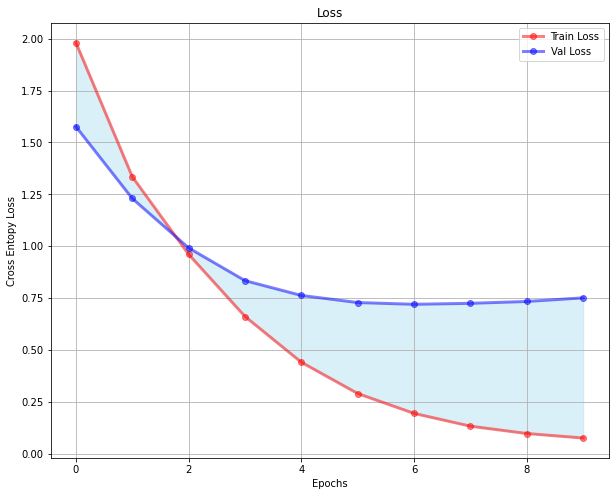

In [ ]:
with plt.style.context('seaborn-pastel'):
  plt.figure(figsize=(10,8))
  plt.plot(np.arange(10),train_losses,'-o',label="Train Loss",linewidth=3,color='red',alpha=0.5)
  plt.plot(np.arange(10),val_losses,'-o',label="Val Loss",linewidth=3,color='blue',alpha=0.5)
  plt.grid(True)
  plt.legend()
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Cross Entopy Loss")
  plt.fill_between(np.arange(10), train_losses,val_losses,color='skyblue',alpha=0.3)
  plt.show()


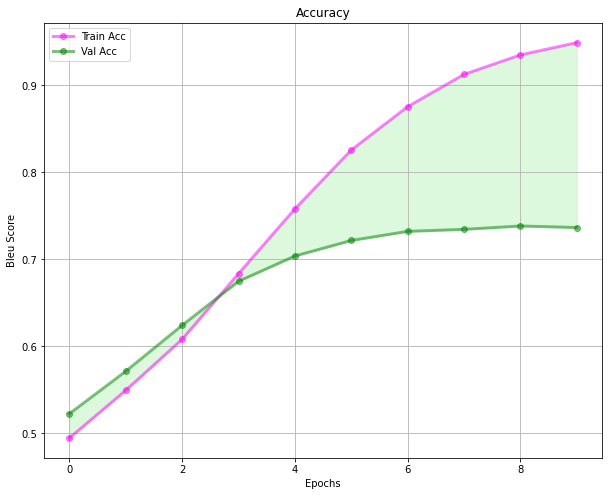

In [ ]:
with plt.style.context('seaborn-pastel'):
  plt.figure(figsize=(10,8))
  plt.plot(np.arange(10),train_accuracy,'-o',label="Train Acc",linewidth=3,color='magenta',alpha=0.5)
  plt.plot(np.arange(10),val_accuracy,'-o',label="Val Acc",linewidth=3,color='green',alpha=0.5)
  plt.grid(True)
  plt.legend()
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Bleu Score")
  plt.fill_between(np.arange(10), train_accuracy,val_accuracy,color='lightgreen',alpha=0.3)
  plt.show()


In [ ]:
def evaluate(spanish):
  attention_plot = np.zeros((max_len_targ,max_len_inp)) # for the attention plot
  sentence = preprocess_sentence(spanish) # preprocessing the spanish sentence
  inputs = [inp_lang_tokenizer.word_index[i] for i in sentence.split()] # converting words into tokens/numbers
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], # zero padding the input 
                                                         maxlen=max_len_inp,
                                                         padding='post')
  # input is a list so we need to coonvert it into a tensor
  inputs = tf.reshape(tf.convert_to_tensor(value=inputs),shape=(1,-1)) # now input is a (max_len_input,) tensor  

  result = ''
  pre_attention_vals, prev_hidden = encoder(inputs)
  dec_input = tf.fill(dims=(1,1),value=targ_lang_tokenizer.word_index["<start>"])

  # using the greedy method, this is not the right way, please use beam search instead
  for t in range(max_len_targ):
    if t==0:
        prev_cell = None
    predictions, prev_hidden, prev_cell, attention_weights = decoder(dec_input, pre_attention_vals, prev_hidden,1, prev_cell)

    attention_plot[t,:] = (attention_weights).numpy().reshape(1,-1)
    pred_token = tf.reduce_sum(tf.argmax(predictions,axis=-1)).numpy()
    result += targ_lang_tokenizer.index_word[pred_token] + ' '
    if targ_lang_tokenizer.index_word[pred_token] == "<end>":
      return result.rstrip(), sentence, attention_plot
    dec_input = tf.fill(dims=(1,1),value=pred_token)
  return result.rstrip(), sentence, attention_plot



In [ ]:
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='gray')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


In [ ]:
def translate(spanish):
  result, sentence, attention_plot = evaluate(spanish)

  print('Input: %s' % (sentence))
  print('Predicted translation: {}'.format(result))

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))


In [ ]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))


Input: <start> todavia estan en casa ? <end>
Predicted translation: <start> are you still at home ? <end>


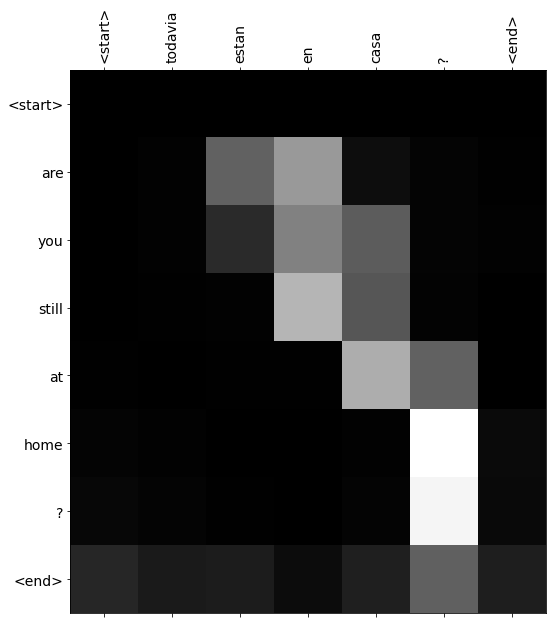

In [ ]:
translate(u'todavía están en casa ?')
